## 基本函数定义

In [46]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import weight_norm
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

### 数据准备

In [93]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [94]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"

    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5

    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5

    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5

    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5

    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5

    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5

    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5

    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [95]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [96]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[s_begin: s_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[s_begin: s_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size, drop_last=False)

    return X, y, X_stamp, y_stamp, data_loader

# GAN（生成对抗式网络）

## 基本概念

GAN的全称是Generative adversarial network，中文翻译过来就是生成对抗网络。生成对抗网络其实是两个网络的组合：生成网络（Generator）负责生成模拟数据；判别网络（Discriminator）负责判断输入的数据是真实的还是生成的。生成网络要不断优化自己生成的数据让判别网络判断不出来，判别网络也要优化自己让自己判断得更准确。二者关系形成对抗，因此叫对抗网络。

GAN通过对某一事物大量数据的学习，来学习总结出其在数学层面上的分布规律，构建出合理的映射函数，从而解决现实问题。

![示例图片](../images/p40.png)

生成器(Generator)：通过机器生成数据（大部分情况下是图像），最终目的是“骗过”判别器。

判别器(Discriminator)：判断这张图像是真实的还是机器生成的，目的是找出生成器做的“假数据”。

生成器生成假数据，然后将生成的假数据和真数据都输入判别器，判别器要判断出哪些是真的哪些是假的。判别器第一次判别出来的肯定有很大的误差，然后我们根据误差来优化判别器。现在判别器水平提高了，生成器生成的数据很难再骗过判别器了，所以我们得反过来优化生成器，之后生成器水平提高了，然后反过来继续训练判别器，判别器水平又提高了，再反过来训练生成器，就这样循环往复，直到达到纳什均衡。

**生成网络的损失函数：**
$$L_G=H(1,D(G(z)))$$
上式中，$G$ 代表生成网络，$D $代表判别网络，$H$ 代表交叉熵，$z$ 是输入随机数据。$D(G(z))$是对生成数据的判断概率，1代表数据绝对真实，0代表数据绝对虚假。$H(1,D(G(z)))$代表判断结果与1的距离。显然生成网络想取得良好的效果，那就要做到，让判别器将生成数据判别为真数据（即$D(G(z))$与1的距离越小越好）。

**判别网络的损失函数：**
$$L_D=H(1,D(x))+H(0,D(G(z)))$$
上式中，$x$是真实数据，这里要注意的是，$H(1,D(x))$代表真实数据与1的距离，$H(0,D(G(z)))$代表生成数据与0的距离。显然，识别网络要想取得良好的效果，那么就要做到，在它眼里，真实数据就是真实数据，生成数据就是虚假数据（即真实数据与1的距离小，生成数据与0的距离小）。
 

**优化原理**：生成网络和判别网络有了损失函数，就可以基于各自的损失函数，利用误差反向传播（Backpropagation）(BP)反向传播算法和最优化方法(如梯度下降法)来实现参数的调整），不断提高生成网络和判别网络的性能（最终生成网络和判别网络的成熟状态就是学习到了合理的映射函数）。

## WGAN

### Wasserstein距离

WGAN引入了Wasserstein距离（也称为地雷杰斯坦距离或汉明斯坦距离）作为GAN的目标函数，用于衡量真实分布和生成分布之间的差异。Wasserstein距离具有更好的数学性质，尤其是当两个分布有重叠时，它依然是可导的。这使得训练过程更加稳定，避免了传统GAN中 Jensen-Shannon 散度等指标可能出现的问题。


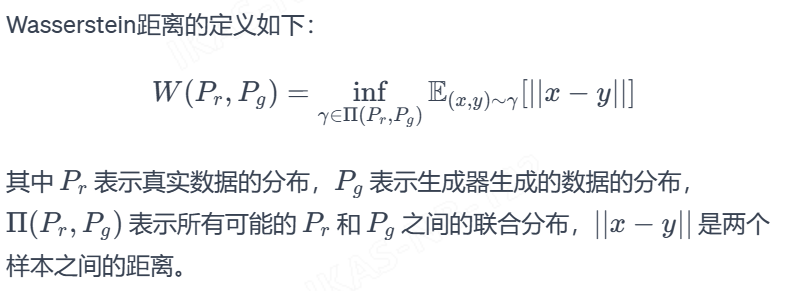

### 梯度裁剪

梯度裁剪（Gradient Clipping）是深度学习中的一种优化技术，主要用于防止梯度爆炸的问题。当神经网络训练时，梯度值可能变得非常大，导致权重更新过大，进而影响模型的稳定性和收敛性。梯度裁剪通过限制梯度的大小，防止它们超过设定的阈值，从而解决这个问题。

在实践中，梯度裁剪通常在每个训练迭代之后应用于模型的梯度。具体步骤如下：

- 计算模型参数关于损失函数的梯度。
- 计算梯度的范数（通常是L2范数）。
- 如果梯度的范数超过了预先设定的阈值，就按比例缩放梯度，使其范数等于阈值。
梯度裁剪的公式如下：

$$clipped_{gradient}=\frac{threshold}{||gradients||}×gradients$$

其中，threshold 是设定的梯度阈值，gradients 是计算得到的梯度。

梯度裁剪有助于避免梯度爆炸的问题，提高模型的稳定性和训练效果。这一技术通常用于循环神经网络（Recurrent Neural Networks，RNN）等架构，因为它们更容易受到梯度爆炸的影响。在许多深度学习框架中，梯度裁剪往往可以通过设置相应的参数或调用相应的函数来实现。

## 数据准备

In [52]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [53]:
# 数据划分
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/GAN'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [54]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 0,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18407, 6, 2]),y_size: torch.Size([18407, 6, 2]),loader_len: 576
X_size: torch.Size([2626, 6, 2]),y_size: torch.Size([2626, 6, 2]),loader_len: 83
X_size: torch.Size([5256, 6, 2]),y_size: torch.Size([5256, 6, 2]),loader_len: 165


## 模型定义

In [55]:
# 定义生成器
class Generator(nn.Module):
    def __init__(self, c_in, d_model, c_out, dropout):
        super(Generator, self).__init__()
        # 输入维度为 (batch_size, c_in, seq_len)
        self.conv1 = nn.Conv1d(c_in, d_model, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(d_model, c_out, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.dropout(torch.relu(self.conv1(x)))
        out = self.dropout(torch.relu(self.conv2(out)))
        out = out.permute(0, 2, 1)
        return out

# 定义判别器
class Discriminator(nn.Module):
    def __init__(self, c_in, d_model, ex_model, dropout):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(c_in, d_model)
        self.linear2 = nn.Linear(d_model, ex_model)
        self.linear3 = nn.Linear(ex_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.dropout(out)
        out = self.linear3(out)
        return out

## 模型训练

In [56]:
def train(train_args, generator_args, discriminator_args):
    # 参数配置
    generator_name = train_args['generator_name']  # 生成器模型名称
    discriminator_name = train_args['discriminator_name']  # 判别器模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 可选'cuda'和'cpu'
    patience = train_args['patience']
    clip_value = train_args['clip_value'] # 裁剪值
    batch_size = train_args['batch_size']
    seq_len = train_args['seq_len']
    c_in = generator_args['c_in']

    # 检查可用device
    device = torch.device(device)

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 定义模型
    generator = generator_name(**generator_args).to(device)
    discriminator = discriminator_name(**discriminator_args).to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # 损失函数值
    G_losses, D_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        generator.train()
        discriminator.train()
        total_G_loss = 0
        total_D_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将输入数据和标签移至device
            inputs_batch, targets_batch = batch_x.to(device), batch_y.to(device)

            # 训练生成器
            optimizer_G.zero_grad()
            fake_data = generator(torch.randn(
                batch_size, seq_len, c_in).to(device))
            loss_G = -torch.mean(discriminator(fake_data))
            loss_G.backward()
            optimizer_G.step()

            # 训练判别器
            optimizer_D.zero_grad()
            real_data = inputs_batch
            loss_real = -torch.mean(discriminator(real_data))
            fake_data = generator(torch.randn(
                batch_size, seq_len, c_in).to(device))
            loss_fake = torch.mean(discriminator(fake_data))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # 在训练生成器和判别器之前添加梯度裁剪
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # 计算每个batch的loss和
            total_G_loss += loss_G.item()
            total_D_loss += loss_D.item()

        # 计算每个epoch的损失平均
        avg_G_loss = total_G_loss / len(train_loader)
        avg_D_loss = total_D_loss / len(train_loader)

        # 记录所有epoch的loss
        G_losses.append(avg_G_loss)
        D_losses.append(avg_D_loss)

        # 打印训练过程
        print(
            f'Epoch [{epoch}/{n_epochs}], Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}')

        # 设置早停
        early_stopping(avg_D_loss, generator, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

    # 绘制损失函数图
    def plot_loss(G_losses, D_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')  # 绘制背景色
        plt.grid(axis='y', linewidth=0.35)  # 绘制网格
        plt.plot(G_losses, linestyle='-', color='#11b3b6')
        plt.plot(D_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Generator", "Discriminator"])
        plt.show()
    if plots:
        plot_loss(G_losses, D_losses)

    return generator

  5%|████▏                                                                              | 1/20 [00:05<01:46,  5.59s/it]

Epoch [0/20], Generator Loss: -0.0095, Discriminator Loss: -0.0054
Validation loss decreased (inf --> -0.005381).  Saving model ...


 10%|████████▎                                                                          | 2/20 [00:11<01:39,  5.53s/it]

Epoch [1/20], Generator Loss: -0.0110, Discriminator Loss: -0.0079
Validation loss decreased (-0.005381 --> -0.007938).  Saving model ...


 15%|████████████▍                                                                      | 3/20 [00:16<01:34,  5.53s/it]

Epoch [2/20], Generator Loss: -0.0089, Discriminator Loss: -0.0079
EarlyStopping counter: 1 out of 5


 20%|████████████████▌                                                                  | 4/20 [00:22<01:28,  5.52s/it]

Epoch [3/20], Generator Loss: -0.0098, Discriminator Loss: -0.0079
EarlyStopping counter: 2 out of 5


 25%|████████████████████▊                                                              | 5/20 [00:27<01:22,  5.51s/it]

Epoch [4/20], Generator Loss: -0.0095, Discriminator Loss: -0.0079
EarlyStopping counter: 3 out of 5


 30%|████████████████████████▉                                                          | 6/20 [00:33<01:16,  5.49s/it]

Epoch [5/20], Generator Loss: -0.0115, Discriminator Loss: -0.0079
EarlyStopping counter: 4 out of 5


 35%|█████████████████████████████                                                      | 7/20 [00:38<01:12,  5.57s/it]

Epoch [6/20], Generator Loss: -0.0095, Discriminator Loss: -0.0079
Validation loss decreased (-0.007938 --> -0.007939).  Saving model ...


 40%|█████████████████████████████████▏                                                 | 8/20 [00:44<01:07,  5.62s/it]

Epoch [7/20], Generator Loss: -0.0094, Discriminator Loss: -0.0079
EarlyStopping counter: 1 out of 5


 45%|█████████████████████████████████████▎                                             | 9/20 [00:50<01:01,  5.59s/it]

Epoch [8/20], Generator Loss: -0.0100, Discriminator Loss: -0.0079
EarlyStopping counter: 2 out of 5


 50%|█████████████████████████████████████████                                         | 10/20 [00:55<00:55,  5.58s/it]

Epoch [9/20], Generator Loss: -0.0103, Discriminator Loss: -0.0079
EarlyStopping counter: 3 out of 5


 55%|█████████████████████████████████████████████                                     | 11/20 [01:01<00:50,  5.58s/it]

Epoch [10/20], Generator Loss: -0.0107, Discriminator Loss: -0.0080
Validation loss decreased (-0.007939 --> -0.008035).  Saving model ...


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:06<00:44,  5.59s/it]

Epoch [11/20], Generator Loss: -0.0112, Discriminator Loss: -0.0079
EarlyStopping counter: 1 out of 5


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:12<00:39,  5.65s/it]

Epoch [12/20], Generator Loss: -0.0108, Discriminator Loss: -0.0079
EarlyStopping counter: 2 out of 5


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:18<00:34,  5.72s/it]

Epoch [13/20], Generator Loss: -0.0094, Discriminator Loss: -0.0079
EarlyStopping counter: 3 out of 5


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:24<00:28,  5.71s/it]

Epoch [14/20], Generator Loss: -0.0098, Discriminator Loss: -0.0079
EarlyStopping counter: 4 out of 5


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:29<00:29,  5.99s/it]

Epoch [15/20], Generator Loss: -0.0107, Discriminator Loss: -0.0079
EarlyStopping counter: 5 out of 5
Early stopping!


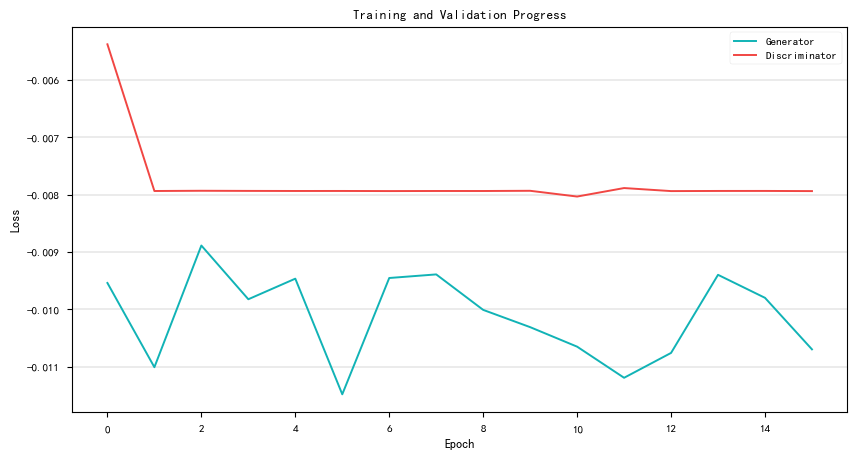

In [57]:
# 构造参数字典
params3 = {
    "train_args": {
        "generator_name": Generator,
        "discriminator_name": Discriminator,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "patience": 5,
        "learning_rate": 0.001,
        "model_path": "../outputs/best_models/GAN",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
        "clip_value": 0.01,
        "batch_size": 32,
        "seq_len": 6,
    },
    "generator_args": {
        'c_in': 2,
        'd_model': 128,
        'c_out': 2,
        'dropout': 0.1
    },
    "discriminator_args": {
        'c_in': 2,
        'd_model': 128,
        'ex_model': 64,
        'dropout': 0.1
    },
}
generator = train(**params3)

## 数据生成

In [64]:
# 生成单步数据
def generator_gan(data, seq_len, c_out, num_samples, scaler, device, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))
    # 检查可用device
    device = torch.device(device)

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_len) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_len, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        # 确保梯度不变
        with torch.no_grad():
            model.eval()
            y_pred = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_len, c_out))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [65]:
# 生成时序数据
params4 = {
    "data": ts_data,
    "seq_len": 6,
    "c_out": 2,
    "num_samples": 3000,
    "scaler": x_scaler,
    "device": 'cuda',
    "model": generator,
}
new_data = generator_gan(**params4)

## 分布差异

KL散度: 3.147503386149521


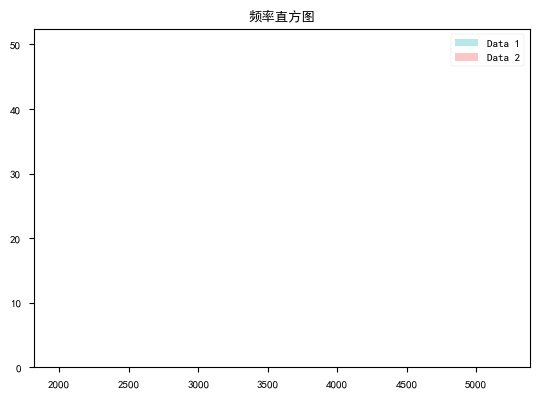

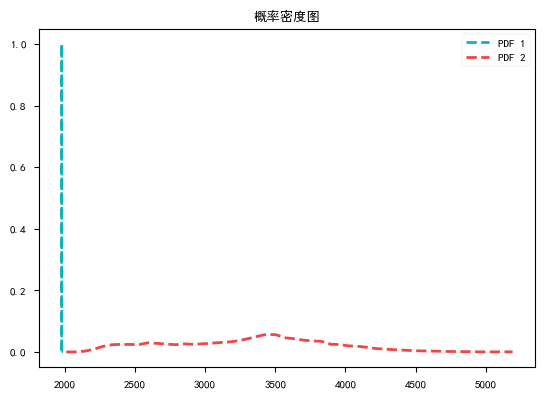

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL散度:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 
plt.title('频率直方图')

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
# 显示图例和标题
plt.legend()
plt.title('概率密度图')

plt.show()

# VAE（变分自编码器）

详见05.时间序列

## 数据准备

In [97]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [98]:
# 数据划分
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/VAE'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [99]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 0,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18407, 6, 2]),y_size: torch.Size([18407, 6, 2]),loader_len: 576
X_size: torch.Size([2626, 6, 2]),y_size: torch.Size([2626, 6, 2]),loader_len: 83
X_size: torch.Size([5256, 6, 2]),y_size: torch.Size([5256, 6, 2]),loader_len: 165


## 模型定义

In [100]:
# 定义变分自编码器模型
class VAE(nn.Module):
    def __init__(self, c_in, d_model, ex_model):
        super(VAE, self).__init__()

        # Encoder
        self.encoder_lstm = nn.LSTM(
            c_in, d_model, num_layers=1, batch_first=True, bidirectional=True)  # LSTM用于编码输入序列
        self.fc_mean = nn.Linear(d_model*2, ex_model)  # 输出均值
        self.fc_logvar = nn.Linear(d_model*2, ex_model)  # 输出对数方差

        # Decoder
        self.decoder_lstm = nn.LSTM(
            ex_model, d_model, num_layers=1, batch_first=True, bidirectional=True)  # LSTM用于解码潜在表示
        self.fc_output = nn.Linear(d_model*2, c_in)  # 输出重建的序列

    def encode(self, x):
        x, (encoder_hidden, encoder_cell) = self.encoder_lstm(x)  # LSTM编码器的输出
        mean = self.fc_mean(x)  # 计算均值
        logvar = self.fc_logvar(x)  # 计算对数方差
        return mean, logvar, encoder_hidden, encoder_cell

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)  # 计算标准差
        eps = torch.randn_like(std)  # 从标准正态分布中采样噪声，并生成一个与输入张量形状相同的张量，目的是对抗
        return mean + eps * std  # 重新参数化，随着损失函数变小，使其服从标准正态分布

    def decode(self, z):
        decoder_hidden, decoder_cell = self.encoder_hidden, self.encoder_cell
        x, _ = self.decoder_lstm(
            z, (decoder_hidden, decoder_cell))  # z服从标准正态分布
        x = self.fc_output(x)  # 输出重建的序列
        return x

    def forward(self, x):
        mean, logvar, self.encoder_hidden, self.encoder_cell = self.encode(
            x)  # 编码输入序列
        # 重参数化，形状为(batch_size, seq_len, latent_dim)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)  # 解码潜在表示
        return x_recon, mean, logvar

## 模型训练

In [101]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 可选'cuda'和'cpu'
    patience = train_args['patience']
    loss = train_args['loss'] # 损失函数

    # 检查可用device
    device = torch.device(device)

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 定义变分自编码器的损失函数
    def vae_loss(x_recon, x, mean, logvar):
        # 重建损失（MSE损失）
        recon_loss = nn.functional.mse_loss(x_recon, x)

        # KL散度损失，KL散度通常用于衡量潜在空间中的编码分布与先验分布（通常是标准正态分布）之间的差异。
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) # 散度越小意味着两个分布越接近

        return recon_loss + kl_loss

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss

    # 损失函数值
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至device
            inputs_batch = batch_x.to(device)
            targets_batch = batch_y.to(device)
            # 清空梯度
            optimizer.zero_grad()
            x_recon, mean, logvar = model(inputs_batch)
            train_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                inputs_batch = batch_x.to(device)
                targets_batch = batch_y.to(device)
                x_recon, mean, logvar = model(inputs_batch)
                val_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
    
    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')  # 绘制背景色
        plt.grid(axis='y', linewidth=0.35)  # 绘制网格
        plt.plot(val_losses, linestyle='-', color='#11b3b6')
        plt.plot(train_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
        
    return model

  5%|████▏                                                                              | 1/20 [00:04<01:20,  4.24s/it]

Epoch [1/20], Training Loss: 0.1021, Validation Loss: 0.0027
Validation loss decreased (inf --> 0.002727).  Saving model ...


 10%|████████▎                                                                          | 2/20 [00:08<01:17,  4.31s/it]

Epoch [2/20], Training Loss: 0.0021, Validation Loss: 0.0014
Validation loss decreased (0.002727 --> 0.001382).  Saving model ...


 15%|████████████▍                                                                      | 3/20 [00:12<01:11,  4.23s/it]

Epoch [3/20], Training Loss: 0.0012, Validation Loss: 0.0010
Validation loss decreased (0.001382 --> 0.001041).  Saving model ...


 20%|████████████████▌                                                                  | 4/20 [00:16<01:07,  4.25s/it]

Epoch [4/20], Training Loss: 0.0008, Validation Loss: 0.0008
Validation loss decreased (0.001041 --> 0.000759).  Saving model ...


 25%|████████████████████▊                                                              | 5/20 [00:21<01:02,  4.18s/it]

Epoch [5/20], Training Loss: 0.0006, Validation Loss: 0.0007
Validation loss decreased (0.000759 --> 0.000675).  Saving model ...


 30%|████████████████████████▉                                                          | 6/20 [00:25<00:57,  4.12s/it]

Epoch [6/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000675 --> 0.000486).  Saving model ...


 35%|█████████████████████████████                                                      | 7/20 [00:29<00:53,  4.08s/it]

Epoch [7/20], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000486 --> 0.000446).  Saving model ...


 40%|█████████████████████████████████▏                                                 | 8/20 [00:33<00:49,  4.10s/it]

Epoch [8/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 5


 45%|█████████████████████████████████████▎                                             | 9/20 [00:37<00:45,  4.11s/it]

Epoch [9/20], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000446 --> 0.000434).  Saving model ...


 50%|█████████████████████████████████████████                                         | 10/20 [00:41<00:41,  4.11s/it]

Epoch [10/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 5


 55%|█████████████████████████████████████████████                                     | 11/20 [00:45<00:37,  4.13s/it]

Epoch [11/20], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000434 --> 0.000329).  Saving model ...


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:49<00:32,  4.09s/it]

Epoch [12/20], Training Loss: 0.0003, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 5


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:53<00:28,  4.06s/it]

Epoch [13/20], Training Loss: 0.0003, Validation Loss: 0.0003
EarlyStopping counter: 2 out of 5


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:57<00:24,  4.10s/it]

Epoch [14/20], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000329 --> 0.000307).  Saving model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:01<00:20,  4.08s/it]

Epoch [15/20], Training Loss: 0.0003, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 5


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:06<00:16,  4.13s/it]

Epoch [16/20], Training Loss: 0.0002, Validation Loss: 0.0002
Validation loss decreased (0.000307 --> 0.000238).  Saving model ...


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:10<00:12,  4.14s/it]

Epoch [17/20], Training Loss: 0.0002, Validation Loss: 0.0002
Validation loss decreased (0.000238 --> 0.000204).  Saving model ...


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:14<00:08,  4.17s/it]

Epoch [18/20], Training Loss: 0.0002, Validation Loss: 0.0002
EarlyStopping counter: 1 out of 5


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:18<00:04,  4.25s/it]

Epoch [19/20], Training Loss: 0.0002, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:23<00:00,  4.15s/it]

Epoch [20/20], Training Loss: 0.0002, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5


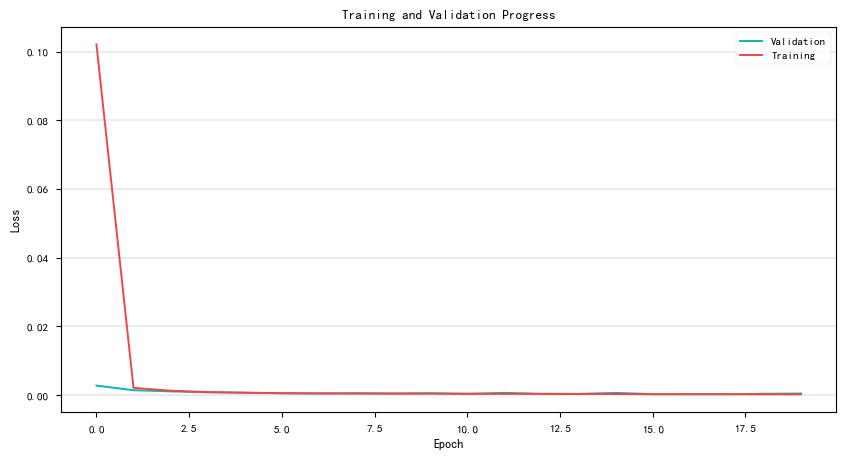

In [86]:
# 构造参数字典
params3 = {
    "train_args": {
        "model_name": VAE,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "patience": 5,
        "learning_rate": 0.001,
        "model_path": "../outputs/best_models/VAE",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
        "loss": nn.MSELoss(),
    },
    "model_args": {
        'c_in': 2,
        'd_model': 64,
        'ex_model': 16
    },
}
model = train(**params3)

## 数据生成

In [87]:
# 生成单步数据
def generator_vae(data, seq_len, ex_model, num_samples, scaler, device, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组

    # 检查可用device
    device = torch.device(device)
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_len) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_len, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        with torch.no_grad():
            model.eval()
            y_pred, mean, logvar = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_len, ex_model))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model.decode(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [88]:
# 生成时序数据
params4 = {
    "data": ts_data,
    "seq_len": 6,
    "ex_model": 16,
    "num_samples": 3000,
    "scaler": x_scaler,
    "device": 'cuda',
    "model": model,
}
new_data = generator_vae(**params4)

In [103]:
new_data.shape

(3000, 2)

## 分布差异

KL散度: 0.019296837927837752


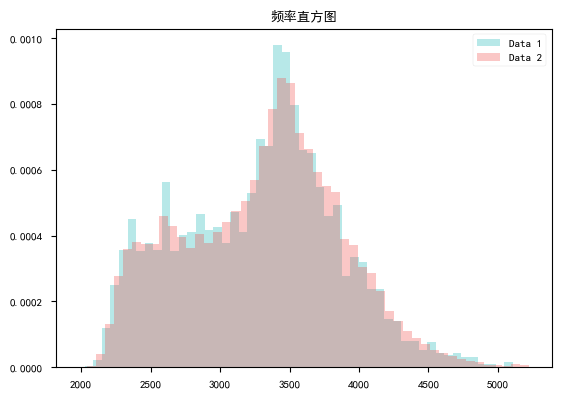

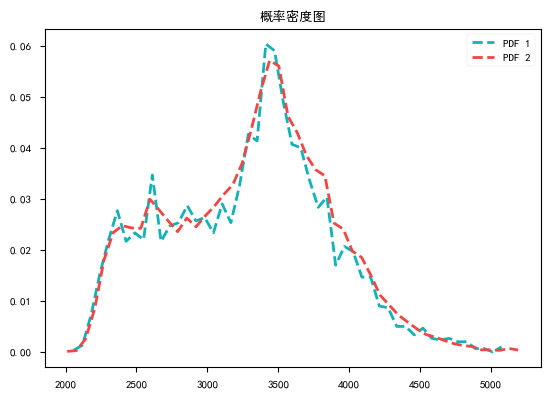

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL散度:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 
plt.title('频率直方图')

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
# 显示图例和标题
plt.legend()
plt.title('概率密度图')

plt.show()